In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import odl
import odl.contrib.tensorflow
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import fnmatch
import mrcfile
#from util import evaluate, display_progress, visualize

In [16]:
def evaluate(test_gt, test_noisy):
    error = loss.eval(feed_dict={gt_tensor: test_gt, noisy_tensor: test_noisy})
    return error
    
def display_progress(i, max_iter, test_gt, test_noisy):
    error = evaluate(test_gt, test_noisy)
    clear_output()
    display('{}/{}, error: {}'.format(i + 1, max_iter, error))

    
def get_tensor_name(tensor, default_name="Ground truth"):
    """Utility function to get the name of a tensor."""
    try:
        name = tensor.name.split('/')[0]
        # Hack for display of data
        if 'noisy' in name:
            name = 'Noisy'
    except AttributeError:
        name = default_name
    return name    
    

def visualize(result_tensor, ground_truth_tensor, noisy_tensor, indices=np.arange(1)):
    """Visualize the result of a reconstruction."""        


    gt, noisy = test_data[0][indices], test_data[1][indices]

 
    result = result_tensor.eval(
        feed_dict={ground_truth_tensor: gt, noisy_tensor: noisy}) 
      
    results_ = [gt, noisy, result]
    names = ['Ground truth', 'Noisy data', get_tensor_name(result_tensor)]
    
    plt.figure(figsize=(15, 3.5))
    plt.subplot(131)
    plt.imshow(gt.squeeze().mean(axis=1))
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(noisy.squeeze().mean(axis=1))
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(result.squeeze().mean(axis=1))
    plt.colorbar()
    plt.show()



def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name).replace("\\", "/"))
    return result

GT_PATH = '/local/scratch/public/sl767/MRC_Data/org/'
SGD_PATH = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/SGD'

NOISY_PATH = SGD_PATH

train_list = find('3*it300_class001.mrc*', NOISY_PATH)
train_amount = len(train_list)
print('# Training data points: ' + str(train_amount))
eval_list = find('9*it300_class001.mrc*', NOISY_PATH)
eval_amount = len(eval_list)
print('# Evaluation data points: ' + str(eval_amount))


def locate_gt(noisy_path):
    pdb_id = noisy_path[-31: -27]
    L = find('*' + pdb_id + '.mrc', GT_PATH)
    if not len(L) == 1:
        raise ValueError('non-unique pdb id: ' + L)
    else:
        return L[0]

def get_single_data(index=None, is_training=True, normalize=True):      
    if is_training:
        L = train_list
    else:
        L = eval_list
    if index is None:
        noisy_path = np.random.choice(L)
    else:
        noisy_path = L[index]
    with mrcfile.open(noisy_path) as mrc:
        noisy = mrc.data
    with mrcfile.open(locate_gt(noisy_path)) as mrc:
        gt = mrc.data
    if normalize:
        gt, noisy = gt/np.sqrt(np.sum(gt ** 2)), noisy/np.sqrt(np.sum(noisy ** 2)) 
    return gt, noisy

def get_batch(batch_size, is_training=True, normalize=True):
    gt = np.zeros(shape=(batch_size, 96, 96, 96, 1))
    noisy = np.zeros(shape=(batch_size, 96, 96, 96, 1))
    for k in range(batch_size):
        gt_tmp, noisy_tmp = get_single_data(is_training=is_training, normalize=normalize)
        gt[k, ..., 0] = gt_tmp
        noisy[k, ..., 0] = noisy_tmp
    return gt, noisy

# Training data points: 31
# Evaluation data points: 1


In [17]:
BATCH_SIZE = 1
test_data = get_batch(batch_size=np.min([eval_amount, 5]), is_training=False)

In [18]:
def train(num_train_batches=100):
    for i in range(num_train_batches):
        ground_truth, noisy = get_batch(BATCH_SIZE) 
        
        session.run(optimizer, feed_dict={gt_tensor: ground_truth, noisy_tensor: noisy})

        display_progress(i, num_train_batches, test_data[0], test_data[1])
        visualize(ground_truth_tensor=gt_tensor, noisy_tensor=noisy_tensor, result_tensor=denoised)

In [19]:
locate_gt(train_list[0])

'/local/scratch/public/sl767/MRC_Data/org/training/3/3A09.mrc'

In [20]:
session = tf.InteractiveSession()

/alt/applic/user-maint/sl767/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [25]:
class orbitLoss(odl.solvers.Functional):
    def __init__(self, domain):
        super(orbitLoss, self).__init__(domain) 
        
    def localReg(self, prod_elem):
        theta = None
        fun = 0.5 * np.sum((prod_elem[0] - prod_elem[1]) ** 2)
        reco_rotated = prod_elem[1] #  The rotated RECONSTRUCTION (NOT GROUND TRUTH)
        return theta, fun, reco_rotated 


    def _call(self, prod_elem):
        return self.localReg(prod_elem)[1] #  optimal funtional value


    # For performance OrbitLossGradientOperator should maybe defined outside of orbitLoss?
    @property
    def gradient(self):
        class OrbitLossGradientOperator(odl.Operator):
            def __init__(self, domain, outer_instance):
                super(OrbitLossGradientOperator, self).__init__(domain=domain, range=domain)
                self.outer_instance = outer_instance
            def _call(self, prod_elem):
                x = prod_elem[0] #  Ground truth
                y = prod_elem[1] #  Reco
                grad_x = np.zeros_like(x) #  Lets set the dervative wrt ground truth-part to zero. It will not propagate back to network params.
                _, _, reco_rotated = self.outer_instance.localReg(prod_elem) #  
                grad_y = reco_rotated - x
                grad = self.domain.element([grad_x, grad_y])
                return grad
               
        return OrbitLossGradientOperator(self.domain, self)


In [26]:
with tf.name_scope('placeholders'):
    gt_tensor = tf.placeholder(tf.float64, shape=[None, 96, 96, 96, 1], name="gt_tensor")
    noisy_tensor = tf.placeholder(tf.float64, shape=[None, 96, 96, 96, 1], name="noisy_tensor")

space = odl.ProductSpace(odl.uniform_discr(min_pt=[0]*3, max_pt=[1]*3, shape=[96]*3), 2)
loss_op = orbitLoss(domain=space)
tf_loss_op = odl.contrib.tensorflow.as_tensorflow_layer(loss_op, name='tf_loss_op')

In [27]:
with tf.name_scope('Denoised'):
    current = noisy_tensor

    for i in range(2):
        dx = tf.contrib.layers.conv3d(current, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv3d(dx, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv3d(dx, num_outputs=1, kernel_size=1,
                                      activation_fn=None)

        current = current + dx

    denoised = current

with tf.name_scope('optimizer_orbit_loss'):
    stack = tf.stack([gt_tensor[0, :, :, :, 0], denoised[0, :, :, :, 0]])[None, ..., None]
    loss = tf_loss_op(stack)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [31]:
tf.global_variables_initializer().run()
train(100)

'2/100, error: [ 0.49446448]'

KeyboardInterrupt: 

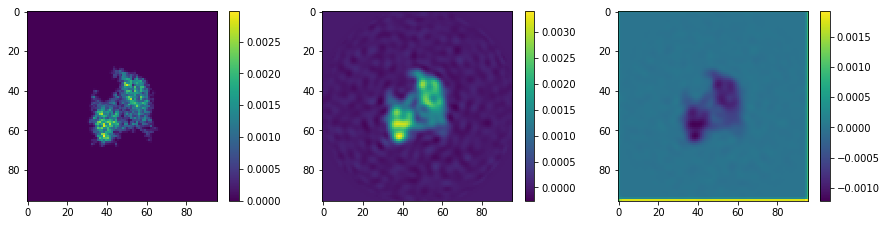

In [30]:
visualize(ground_truth_tensor=gt_tensor, noisy_tensor=noisy_tensor, result_tensor=denoised)

In [15]:
print([np.sum(test_data[k] ** 2) for k in [0,1]])

[8.8442070593219998e-06, 0.04894436807244746]


In [ ]:
? tf.global_variables_initializer()

In [ ]:
loss.eval()

In [ ]:
'2/100, error: [ 0.40670216]'